In [1]:
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
from transformers import RobertaTokenizer
import numpy as np
import matplotlib.pyplot as plt
from parser import DFG_java,DFG_csharp,DFG_python
from parser import (remove_comments_and_docstrings,
                   tree_to_token_index,
                   index_to_code_token,
                   tree_to_variable_index, 
                   detokenize_code, tree_to_token_nodes)
from tree_sitter import Language, Parser
import os
import pickle


def read_examples(split):
    if (split=='valid') or (split=='dev'):
        split='validation'
    dataset = load_dataset('code_x_glue_cc_code_to_code_trans')[split]
    examples = []
    failed_count = 0
    for eg in dataset:
        java, cs = eg['java'][:-1], eg['cs'][:-1]
        assert (java == remove_comments_and_docstrings(java, 'java') )
        assert (cs == remove_comments_and_docstrings(cs, 'cs'))
        examples.append([eg['id'],java,cs])
    print ('No. of pairs', len(examples))
    return pd.DataFrame(examples, columns=['id', 'java', 'cs'])


def get_tokenizer_chars(tokenizer):
    tokenizer_chars = []
    for i in range(tokenizer.vocab_size):
        token = tokenizer.decode(i)
        if len(token)==1:
            tokenizer_chars.append(token)
    tokenizer_chars = [c for c in tokenizer_chars if c!='�']
    return tokenizer_chars


def tokenize_codes_texts(texts, batch_size=1024):
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    tokenizer_chars = get_tokenizer_chars(tokenizer)
    texts = [''.join(filter(lambda c:c in tokenizer_chars, text)) for text in texts]
    N = len(texts)
    tokenized_texts = []
    for start in range(0, len(texts),batch_size):
        tokenized_texts += tokenizer(texts[start:start+batch_size]).input_ids
    return tokenized_texts


def length_stats(s, title=None):
    try:
        if type(s.iloc[0])==str: # a list encoded as str
            lens = s.apply(lambda x:x.count(',')+1)
        else: # a list
            lens = s.apply(len)
    except:
        lens = s # s contains lengths
    y = np.arange(100)
    x = lens.quantile(y/100)
    plt.figure()
    plt.plot(x,y)
    plt.title(title)
    plt.show()
    
    
def get_code_tokens_ranges(data, code_col, code_tokens_col):
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    pbar = data.itertuples()
    ranges = []
    
    for row in pbar:
        code_tokens = [tokenizer.decode(ct) for ct in getattr(row, code_tokens_col)][1:-1] # 1:-1 to remove <s> and </s>
        code2 = ''.join(code_tokens) # may miss some spaces / special chars that are in row.code_col
        code = getattr(row, code_col)
        
        # map each position in code2 to a position in code
        code2_to_code = []
        j=0
        for i in range(len(code2)):
            while code2[i]!=code[j]:
                j += 1
            code2_to_code.append(j)
            
        # map each code token to a range in code
        code2_idx = 0
        curr_ranges = []
        for ct in code_tokens:
            s,e = code2_idx, code2_idx+len(ct)
            code2_idx = e
            curr_ranges.append((min(code2_to_code[s:e]),1+max(code2_to_code[s:e])))
        ranges.append([None]+curr_ranges+[None]) # first and last for <s> and </s>
        
    data[code_tokens_col+'_ranges'] = ranges
    
    
def extract_structure(code, parser):
    # ast
    tree = parser[0].parse(bytes(code,'utf8'))    
    root_node = tree.root_node  
    ast_token_nodes = tree_to_token_nodes(root_node) # leaves
    
    # dfg
    tokens_index = [(node.start_point, node.end_point) for node in ast_token_nodes]
    code=code.split('\n')
    code_tokens=[index_to_code_token(x,code) for x in tokens_index] 
    index_to_code={index:(idx,code_) for idx,(index,code_) in enumerate(zip(tokens_index,code_tokens))}
    try:
        DFG,_ = parser[1](root_node,index_to_code,{}) 
    except:
        DFG = []
    for d in DFG:
        assert (d[2]=='comesFrom' or d[2]=='computedFrom')
    DFG = [(d[1], d[4]) for d in DFG if (len(d[4])>0)] # left comes from right
    return code_tokens, ast_token_nodes, DFG


def format_node_ranges(code, nodes):
    line_lens = [len(line)+1 for line in code.split('\n')]
    line_starts = [0] + list(np.cumsum(line_lens))
    return [(line_starts[node.start_point[0]]+node.start_point[1],
             line_starts[node.end_point[0]]+node.end_point[1]) for node in nodes]
    
    
def add_structure(data, lang):
    LANGUAGE = Language('parser/my-languages2.so', 'c_sharp' if lang=='cs' else lang)
    parser = Parser()
    parser.set_language(LANGUAGE) 
    dfg_function={'python':DFG_python, 'java':DFG_java, 'cs':DFG_csharp, 'c_sharp':DFG_csharp}
    parser = [parser, dfg_function[lang]]
        
    ast_leaf_tokens, ast_leaves, ast_leaf_ranges, dfg_edges = [], [], [], []
    for code in data[lang]:
        curr_code_tokens, curr_ast_leaves, curr_dfg_edges = extract_structure(code, parser)
        ast_leaf_tokens.append(curr_code_tokens)
        ast_leaves.append(curr_ast_leaves)
        ast_leaf_ranges.append(format_node_ranges(code, curr_ast_leaves))
        dfg_edges.append(curr_dfg_edges)
        
    data[lang+'_ast_leaves'] = ast_leaves # list of leaf nodes
    data[lang+'_dfg_edges'] = dfg_edges # list of "left leaf node index comes from right leaf nodes indices"
    data[lang+'_ast_leaf_tokens'] = ast_leaf_tokens # list of code substrings corresponding to each leaf
    data[lang+'_ast_leaf_ranges'] = ast_leaf_ranges # list of (start,end) in code for each leaf node
    
    print ('# '+lang+' samples with failed/empty DFG:', (data[lang+'_dfg_edges'].apply(len)==0).sum())
    
    
def overlap(s1,e1,s2,e2):
    return s1<=s2<e1 or s2<=s1<e2
    
    
def get_leaf_code_token_indices(data, lang):
    ast_leaf_token_idxs = []
    pbar = data.itertuples() if len(data)<=100000 else tqdm(data.itertuples())
    for row in pbar:
        ast_leaf_token_idxs.append([])
        code_tokens_last_idx = len(getattr(row, lang+'_tokens'))-1
        code_tokens_ranges = getattr(row, lang+'_tokens_ranges')
        for s,e in getattr(row, lang+'_ast_leaf_ranges'):
            if s==e: # there are leaves with start_point=end_point
                ast_leaf_token_idxs[-1].append([])
                continue
            j = 1
            while not(overlap(s,e,code_tokens_ranges[j][0],code_tokens_ranges[j][1])):
                j += 1
                if j==code_tokens_last_idx: # can't find code tokens for this leaf
                    break
            if j==code_tokens_last_idx: # can't find code tokens for this leaf
                ast_leaf_token_idxs[-1].append([])
                continue
            curr_leaf_token_idxs = []
            while overlap(s,e,code_tokens_ranges[j][0],code_tokens_ranges[j][1]):
                curr_leaf_token_idxs.append(j)
                j += 1
                if j==code_tokens_last_idx:
                    break
            ast_leaf_token_idxs[-1].append(curr_leaf_token_idxs)
    data[lang+'_ast_leaf_code_token_idxs'] = ast_leaf_token_idxs
    print ('Average # leaves with no matching code tokens:', 
           data[lang+'_ast_leaf_code_token_idxs'].apply(lambda x:sum([1 for xi in x if xi==[]])).mean())
    

def get_lr_path(leaf):
    path = [leaf]
    while path[-1].parent is not None:
        path.append(path[-1].parent)
    return path


def get_ll_sim(p1, p2): 
    common = 1
    for i in range(2, min(len(p1), len(p2))+1):
        if p1[-i]==p2[-i]:
            common += 1
        else:
            break
    return common*common / (len(p1)*len(p2))   


def get_ast_lr_paths_and_ll_sim(data, lang):
    sims = []
    lr_paths = []
    for i,row in tqdm(enumerate(data.itertuples())):
        ast_leaves = getattr(row, lang+'_ast_leaves')
        L = min(len(ast_leaves), 512)
        curr_paths = [get_lr_path(leaf) for leaf in ast_leaves]
        curr_sims = np.ones((L,L))
        for i in range(L-1):
            for j in range(i+1,L):
                curr_sims[i,j] = curr_sims[j,i] = get_ll_sim(curr_paths[i], curr_paths[j])
        sims.append(curr_sims)
        lr_paths.append([[node.type for node in path] for path in curr_paths])
    data.drop(columns=[lang+'_ast_leaves'], inplace=True)
    data[lang+'_ll_sims'] = sims
    data[lang+'_lr_paths_types'] = lr_paths


def process_dfg_edges(data, lang):
    dfg_node_code_token_idxs = []
    dfg_edges = []
    pbar = data.itertuples()  
    for row in pbar:
        curr_dfg_edges = getattr(row, lang+'_dfg_edges')
        if len(curr_dfg_edges)>0:
            nodes = sorted(list(set(np.concatenate([[left]+right for left,right in curr_dfg_edges]))))
        else:
            nodes = []
        node_to_idx = {k:i for i,k in enumerate(nodes)}
        ast_leaf_code_token_idxs = getattr(row, lang+'_ast_leaf_code_token_idxs')
        dfg_node_code_token_idxs.append( [ast_leaf_code_token_idxs[i] for i in nodes] )
        dfg_edges.append( [(node_to_idx[left], [node_to_idx[r] for r in right]) for left,right in curr_dfg_edges] )
    data[lang+'_dfg_edges'] = dfg_edges
    data[lang+'_dfg_node_code_token_idxs'] = dfg_node_code_token_idxs
    
    
def some_more_stats(data, lang):
    node_types = set(np.concatenate(list(data[lang+'_lr_paths_types'].apply(lambda ll:np.concatenate(ll)))))
    print ('# node types:', len(node_types))
    if 'ERROR' in node_types:
        num_error_nodes = data[lang+'_lr_paths_types'].apply(lambda paths:
                        np.mean(['ERROR' in path for path in paths]))
        print ('Distrubution of fraction of leaf-root paths with ERROR node in one code')
        length_stats(num_error_nodes)
    print ('Distrubution of AST depth')
    length_stats(data[lang+'_lr_paths_types'].apply(lambda paths:max([len(p) for p in paths])))          
    print ('Distrubution of # ast leaves per code')
    length_stats(data[lang+'_ast_leaf_code_token_idxs'].apply(len))
    print ('Distrubution of # dfg nodes per code')
    length_stats(data[lang+'_dfg_node_code_token_idxs'].apply(len))
    print ('Distrubution of # dfg edges per code')
    def num_dfg_edges(s):
        if s==[]:
            return 0
        return sum([len(rights) for _,rights in s])
    length_stats(data[lang+'_dfg_edges'].apply(num_dfg_edges))
    return node_types


/home/grads/tsaisindhura/.conda/envs/structcoder/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CodeXGLUE translation

/home/tsaisindhura/anaconda3/envs/structcoder/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




Split=train


Found cached dataset code_x_glue_cc_code_to_code_trans (/home/tsaisindhura/.cache/huggingface/datasets/code_x_glue_cc_code_to_code_trans/default/0.0.0/86dd57d2b1e88c6e589646133b76f2fef9d56c82e933d7f276e8a5b60ab18c34)
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1200.32it/s]


No. of pairs 10300
# java samples with failed/empty DFG: 1443


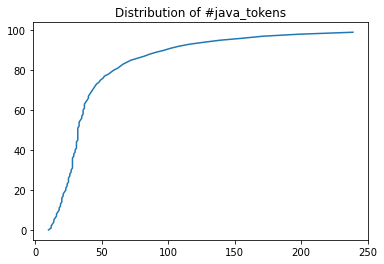

Average # leaves with no matching code tokens: 1.1635922330097088


10300it [00:14, 707.69it/s]


# node types: 172
Distrubution of fraction of leaf-root paths with ERROR node in one code


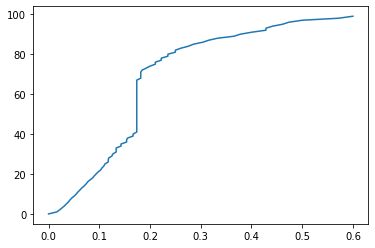

Distrubution of AST depth


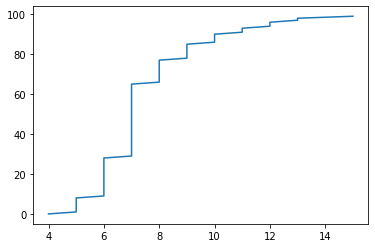

Distrubution of # ast leaves per code


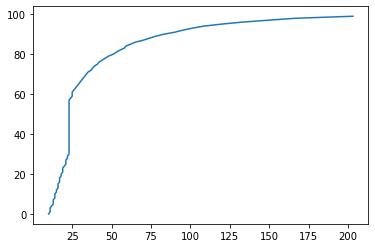

Distrubution of # dfg nodes per code


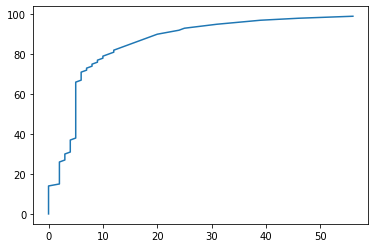

Distrubution of # dfg edges per code


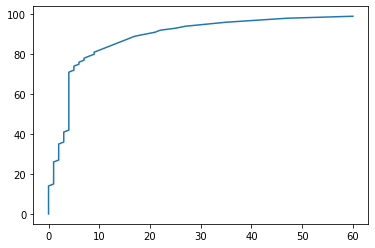

# cs samples with failed/empty DFG: 1202


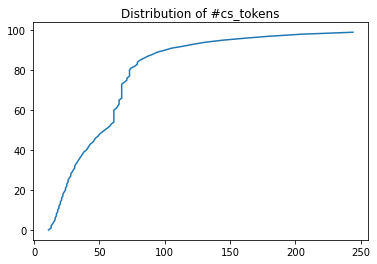

Average # leaves with no matching code tokens: 0.48077669902912623


10300it [00:23, 436.79it/s]


# node types: 213
Distrubution of fraction of leaf-root paths with ERROR node in one code


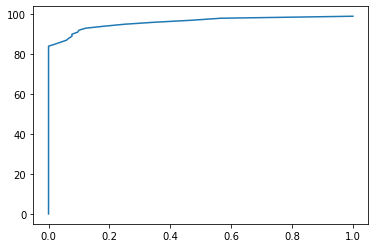

Distrubution of AST depth


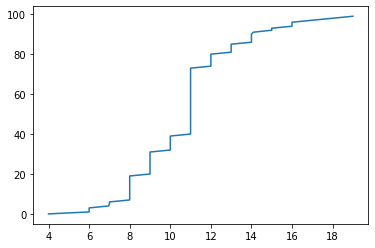

Distrubution of # ast leaves per code


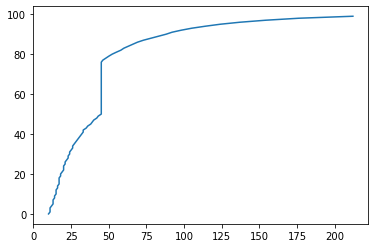

Distrubution of # dfg nodes per code


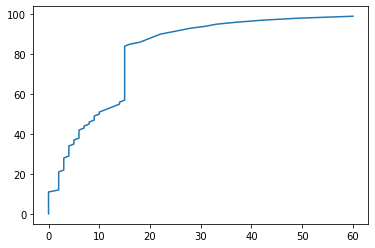

Distrubution of # dfg edges per code


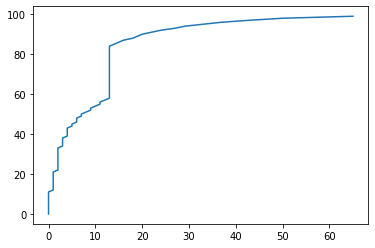



Split=validation


Found cached dataset code_x_glue_cc_code_to_code_trans (/home/tsaisindhura/.cache/huggingface/datasets/code_x_glue_cc_code_to_code_trans/default/0.0.0/86dd57d2b1e88c6e589646133b76f2fef9d56c82e933d7f276e8a5b60ab18c34)
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 700.96it/s]


No. of pairs 500
# java samples with failed/empty DFG: 70


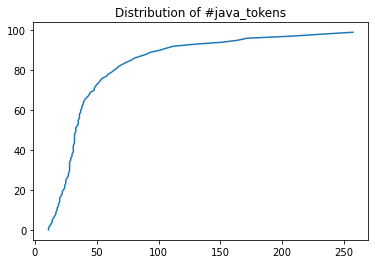

Average # leaves with no matching code tokens: 1.24


500it [00:00, 605.91it/s]


# node types: 139
Distrubution of fraction of leaf-root paths with ERROR node in one code


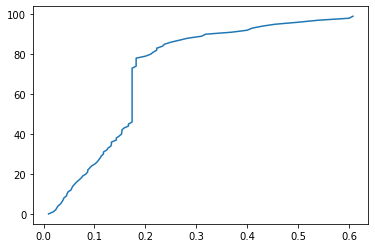

Distrubution of AST depth


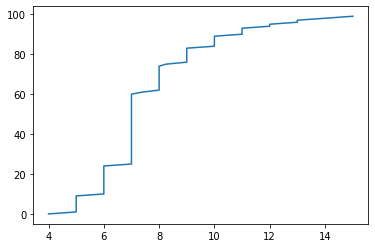

Distrubution of # ast leaves per code


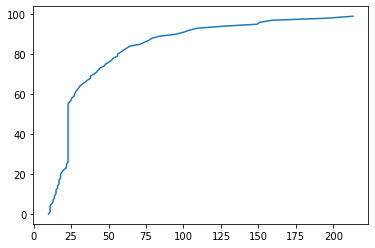

Distrubution of # dfg nodes per code


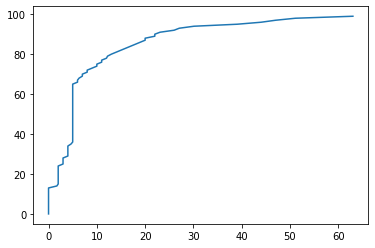

Distrubution of # dfg edges per code


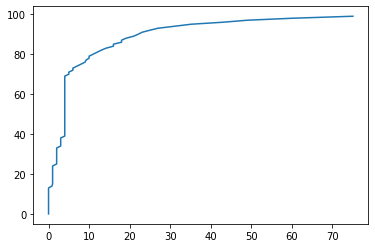

# cs samples with failed/empty DFG: 51


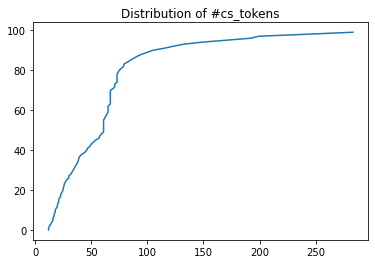

Average # leaves with no matching code tokens: 0.598


500it [00:01, 380.59it/s]


# node types: 153
Distrubution of fraction of leaf-root paths with ERROR node in one code


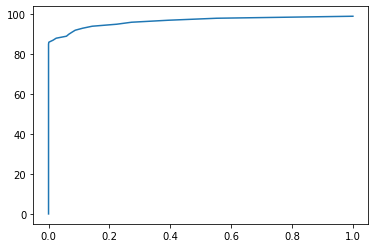

Distrubution of AST depth


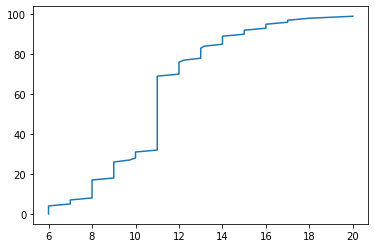

Distrubution of # ast leaves per code


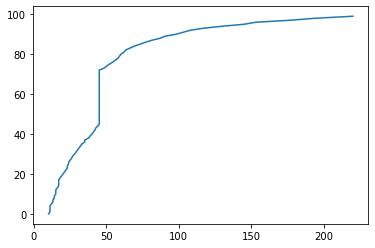

Distrubution of # dfg nodes per code


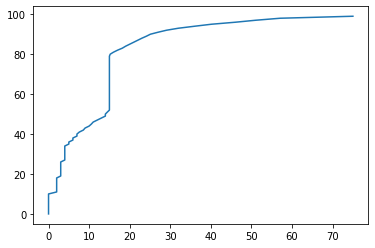

Distrubution of # dfg edges per code


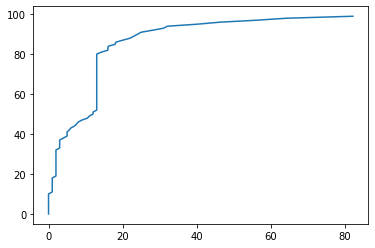



Split=test


Found cached dataset code_x_glue_cc_code_to_code_trans (/home/tsaisindhura/.cache/huggingface/datasets/code_x_glue_cc_code_to_code_trans/default/0.0.0/86dd57d2b1e88c6e589646133b76f2fef9d56c82e933d7f276e8a5b60ab18c34)
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 698.43it/s]


No. of pairs 1000
# java samples with failed/empty DFG: 160


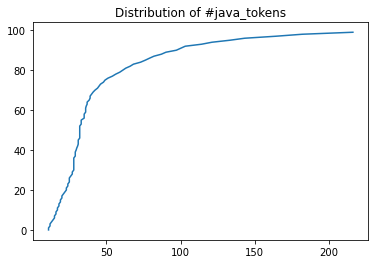

Average # leaves with no matching code tokens: 1.169


1000it [00:01, 741.24it/s]


# node types: 148
Distrubution of fraction of leaf-root paths with ERROR node in one code


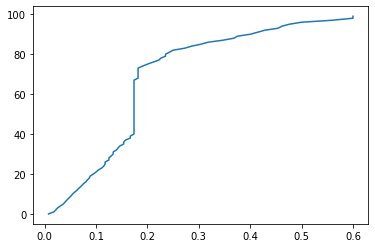

Distrubution of AST depth


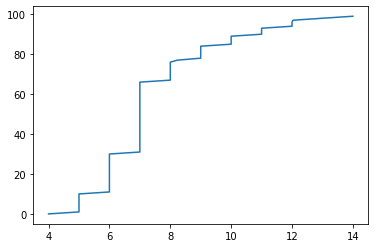

Distrubution of # ast leaves per code


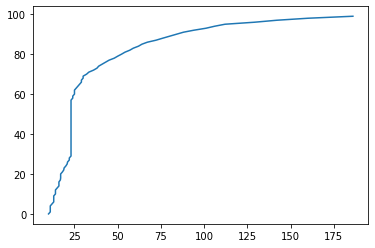

Distrubution of # dfg nodes per code


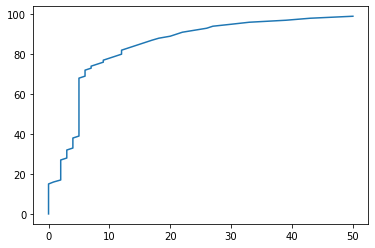

Distrubution of # dfg edges per code


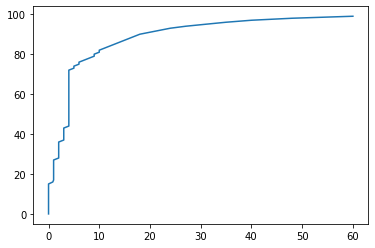

# cs samples with failed/empty DFG: 117


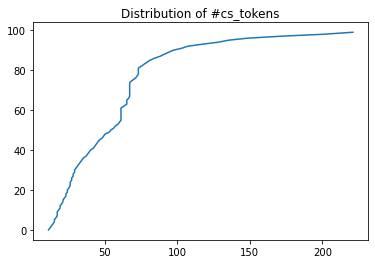

Average # leaves with no matching code tokens: 0.508


1000it [00:02, 497.46it/s]


# node types: 180
Distrubution of fraction of leaf-root paths with ERROR node in one code


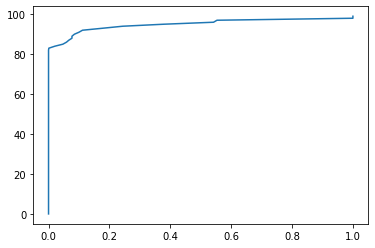

Distrubution of AST depth


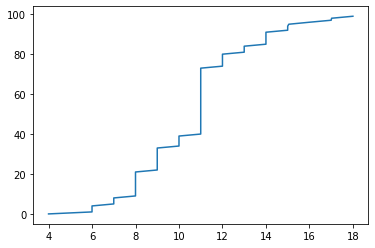

Distrubution of # ast leaves per code


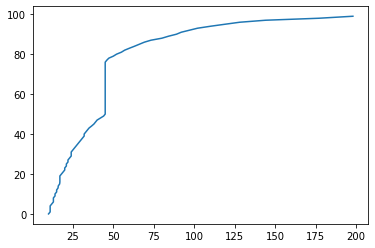

Distrubution of # dfg nodes per code


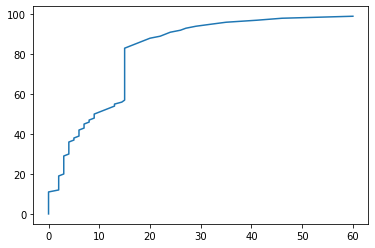

Distrubution of # dfg edges per code


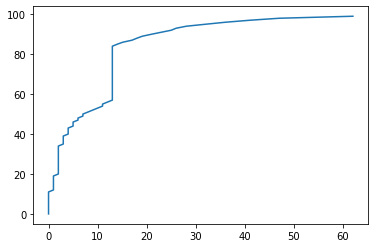

In [1]:
save_dir = 'data/codexglue_translation/'
os.makedirs(save_dir, exist_ok=True)
all_node_types = set()
data_by_split = {}
for split in ['train', 'validation', 'test']:
    print ('\n\nSplit='+split)
    data = read_examples(split) # id, java, cs
    for lang in ['java', 'cs']:
        add_structure(data, lang) # lang_ -> ast_leaves, dfg_edges, ast_leaf_tokens, ast_leaf_ranges
        data[lang+'_tokens'] = tokenize_codes_texts(list(data[lang]))
        length_stats(data[lang+'_tokens'], 'Distribution of #'+lang+'_tokens')
        get_code_tokens_ranges(data, lang, lang+'_tokens') # list of (start,end) one for each code_token
        data.drop(columns=[lang], inplace=True)
        get_leaf_code_token_indices(data, lang)
        data.drop(columns=[lang+c for c in ['_ast_leaf_tokens', '_ast_leaf_ranges', '_tokens_ranges']], 
                  inplace=True)
        get_ast_lr_paths_and_ll_sim(data, lang)
        process_dfg_edges(data, lang)
        more_node_types = some_more_stats(data, lang)
        all_node_types.update(more_node_types)
    data_by_split[split] = data
    
# Map node types to indices.
all_node_types = sorted(list(all_node_types))
node_type_to_ind = {t:i for i,t in enumerate(all_node_types)}
pickle.dump(all_node_types, open(save_dir+'all_node_types.pkl', 'wb'))

# Convert node types on paths to indices.
for split in ['train', 'validation', 'test']:
    for lang in ['java', 'cs']:
        data_by_split[split][lang+'_lr_paths_types'] = data_by_split[split][lang+'_lr_paths_types'].apply(
                                            lambda ll: [[node_type_to_ind[t] for t in path] for path in ll])
        
# Save data. Not converting array cols to strings, storing with pickle.
pickle.dump(data_by_split, open(save_dir+'preprocessed_data_by_split.pkl','wb'))

In [3]:
from datasets import load_dataset
dataset_splits = load_dataset('code_x_glue_cc_code_to_code_trans')
for split in ['train', 'validation', 'test']:
    dataset = dataset_splits[split]
    lines = {'java':[], 'cs':[]}
    for eg in dataset:
        lines['java'].append(eg['java'])
        lines['cs'].append(eg['cs'])
    for lang in ['java','cs']:
        with open('data/codexglue_translation/'+split+'_'+lang+'.txt', 'w') as f:
            lines[lang][-1] = lines[lang][-1][:-1] # to remove last empty line
            f.writelines(lines[lang])        

Found cached dataset code_x_glue_cc_code_to_code_trans (/home/tsaisindhura/.cache/huggingface/datasets/code_x_glue_cc_code_to_code_trans/default/0.0.0/86dd57d2b1e88c6e589646133b76f2fef9d56c82e933d7f276e8a5b60ab18c34)
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 575.09it/s]


## CodeXGLUE generation



Split=train
No. of pairs 100000


Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors


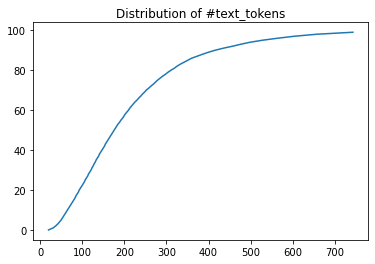

# java samples with failed/empty DFG: 35246


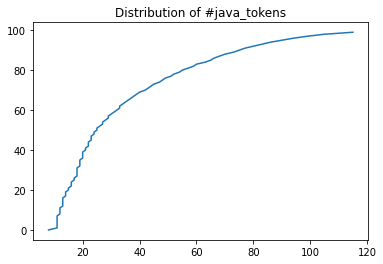

Average # leaves with no matching code tokens: 1.00472


100000it [01:01, 1636.45it/s]


# node types: 174
Distrubution of fraction of leaf-root paths with ERROR node in one code


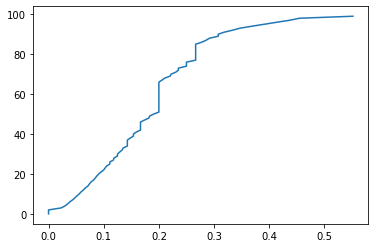

Distrubution of AST depth


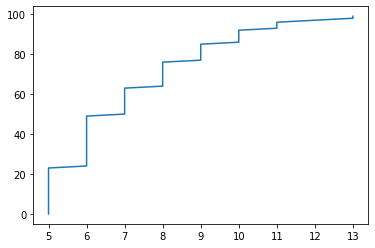

Distrubution of # ast leaves per code


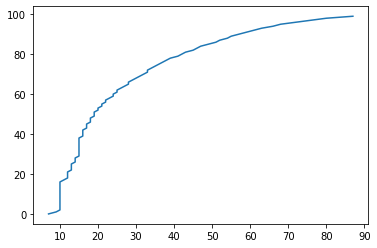

Distrubution of # dfg nodes per code


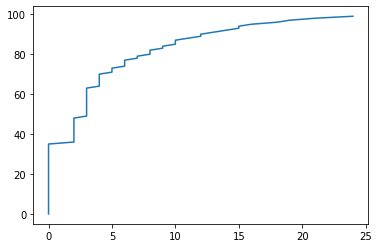

Distrubution of # dfg edges per code


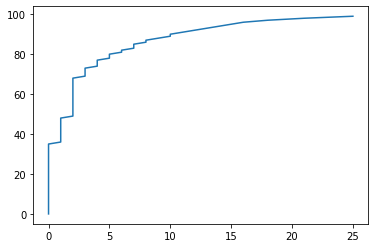



Split=validation
No. of pairs 2000


Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


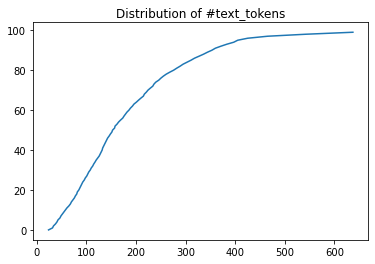

# java samples with failed/empty DFG: 603


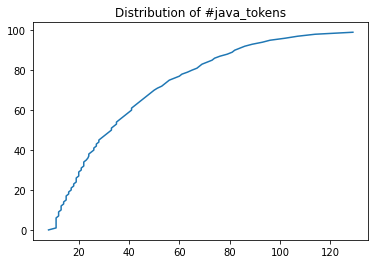

Average # leaves with no matching code tokens: 1.0105


2000it [00:01, 1289.89it/s]


# node types: 152
Distrubution of fraction of leaf-root paths with ERROR node in one code


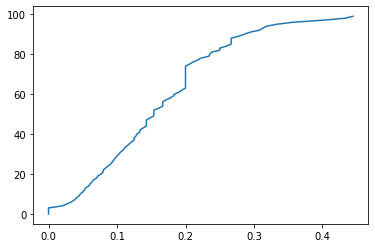

Distrubution of AST depth


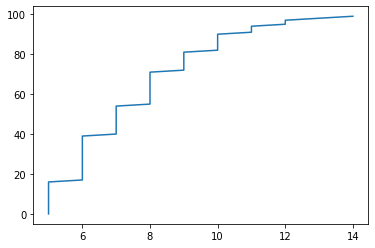

Distrubution of # ast leaves per code


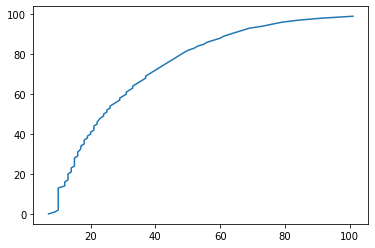

Distrubution of # dfg nodes per code


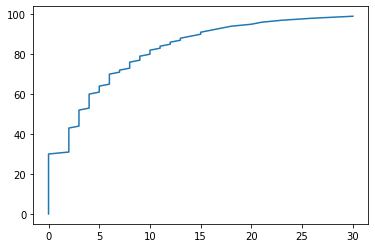

Distrubution of # dfg edges per code


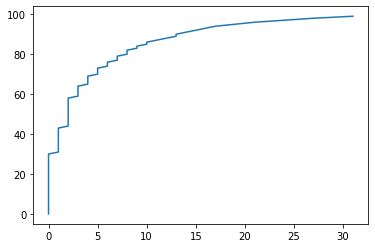



Split=test
No. of pairs 2000


Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors


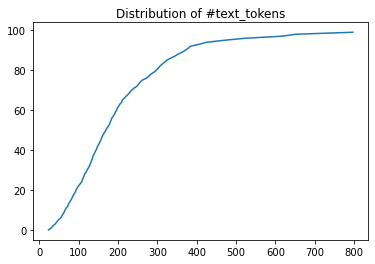

# java samples with failed/empty DFG: 588


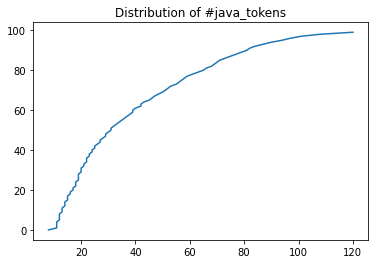

Average # leaves with no matching code tokens: 1.0055


2000it [00:01, 1407.62it/s]


# node types: 151
Distrubution of fraction of leaf-root paths with ERROR node in one code


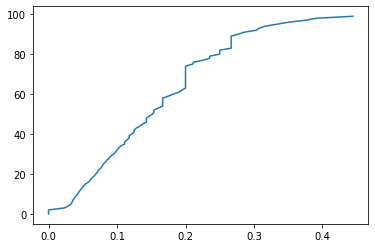

Distrubution of AST depth


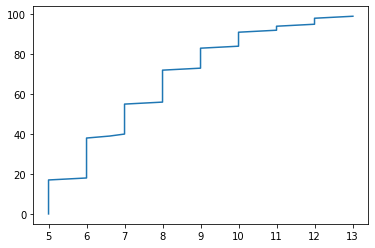

Distrubution of # ast leaves per code


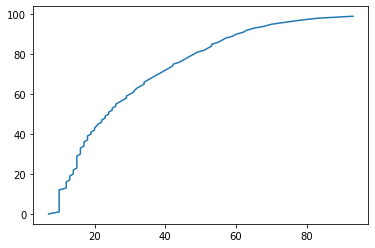

Distrubution of # dfg nodes per code


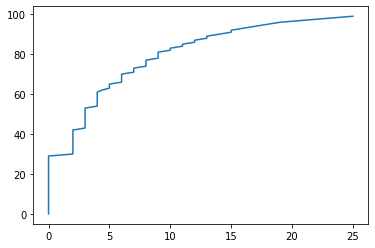

Distrubution of # dfg edges per code


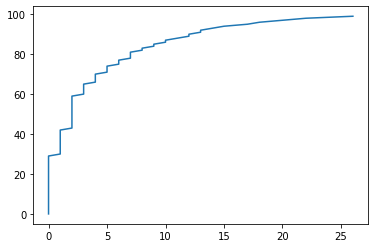

In [4]:
import json 

def read_examples(split):
    if split in ['valid', 'validation']:
        split='dev'
    examples = []
    with open('../datasets/concode/'+split+'.json') as f:
        for idx, line in enumerate(f):
            x = json.loads(line)
            nl, code = x["nl"].strip(), x["code"].strip()
            assert (code == remove_comments_and_docstrings(code, 'java') )
            assert ('\n' not in code)
            examples.append([idx, nl, code])
    print ('No. of pairs', len(examples))
    return pd.DataFrame(examples, columns=['id', 'nl', 'java'])

save_dir = 'data/codexglue_generation/'
os.makedirs(save_dir, exist_ok=True)
all_node_types = set()
data_by_split = {}
lang = 'java'
for split in ['train', 'validation', 'test']:
    print ('\n\nSplit='+split)
    data = read_examples(split) # id, nl, java
    data['nl_tokens'] = tokenize_codes_texts(list(data['nl']))
    length_stats(data['nl_tokens'], 'Distribution of #text_tokens')
    add_structure(data, 'java') # lang_ -> ast_leaves, dfg_edges, ast_leaf_tokens, ast_leaf_ranges
    data[lang+'_tokens'] = tokenize_codes_texts(list(data[lang]))
    length_stats(data[lang+'_tokens'], 'Distribution of #'+lang+'_tokens')
    get_code_tokens_ranges(data, lang, lang+'_tokens') # list of (start,end) one for each code_token
    with open(save_dir+split+'_'+lang+'.txt', 'w') as f:
        lines = [code+'\n' for code in data[lang]]
        lines[-1] = lines[-1][:-1] # to remove last empty line
        f.writelines(lines) 
    data.drop(columns=['nl', lang], inplace=True)
    get_leaf_code_token_indices(data, lang)
    data.drop(columns=[lang+c for c in ['_ast_leaf_tokens', '_ast_leaf_ranges', '_tokens_ranges']], inplace=True)
    get_ast_lr_paths_and_ll_sim(data, lang)
    process_dfg_edges(data, lang)
    more_node_types = some_more_stats(data, lang)
    all_node_types.update(more_node_types)
    data_by_split[split] = data
    
# Map node types to indices.
all_node_types = sorted(list(all_node_types))
node_type_to_ind = {t:i for i,t in enumerate(all_node_types)}
pickle.dump(all_node_types, open(save_dir+'all_node_types.pkl', 'wb'))

# Convert node types on paths to indices.
for split in ['train', 'validation', 'test']:
    data_by_split[split][lang+'_lr_paths_types'] = data_by_split[split][lang+'_lr_paths_types'].apply(
                                            lambda ll: [[node_type_to_ind[t] for t in path] for path in ll])
        
# Save data. Not converting array cols to strings, storing with pickle.
pickle.dump(data_by_split, open(save_dir+'preprocessed_data_by_split.pkl','wb'))

## APPS generation



Split=train


No config specified, defaulting to: apps/all
Found cached dataset apps (/home/grads/tsaisindhura/.cache/huggingface/datasets/codeparrot___apps/all/0.0.0/04ac807715d07d6e5cc580f59cdc8213cd7dc4529d0bb819cca72c9f8e8c1aa5)
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 414.97it/s]


No. of pairs 5000


Token indices sequence length is longer than the specified maximum sequence length for this model (753 > 512). Running this sequence through the model will result in indexing errors


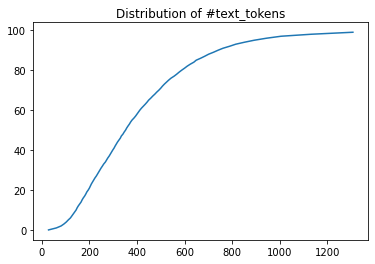

No. of pairs 117232
# python samples with failed/empty DFG: 545


Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


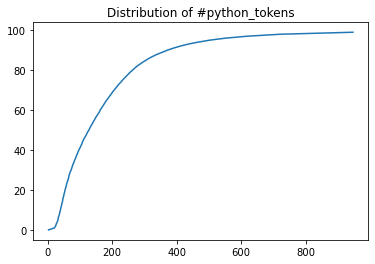

117232it [05:57, 327.89it/s] 


Average # leaves with no matching code tokens: 10.9705626450116


117232it [28:00, 69.75it/s] 


# node types: 178
Distrubution of fraction of leaf-root paths with ERROR node in one code


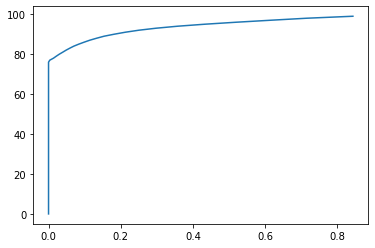

Distrubution of AST depth


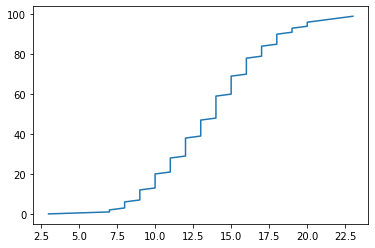

Distrubution of # ast leaves per code


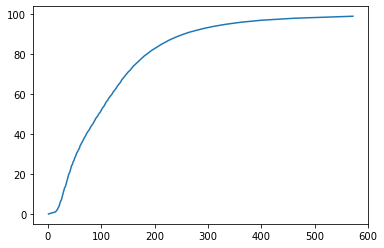

Distrubution of # dfg nodes per code


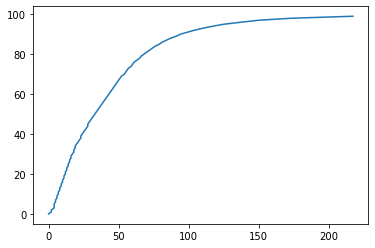

Distrubution of # dfg edges per code


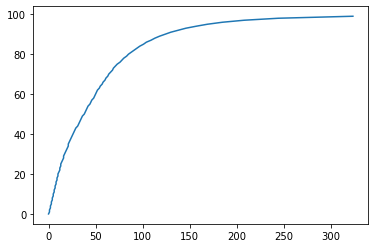



Split=test


No config specified, defaulting to: apps/all
Found cached dataset apps (/home/grads/tsaisindhura/.cache/huggingface/datasets/codeparrot___apps/all/0.0.0/04ac807715d07d6e5cc580f59cdc8213cd7dc4529d0bb819cca72c9f8e8c1aa5)
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 569.45it/s]


No. of pairs 5000


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


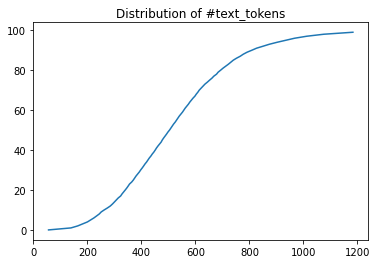

Done.


In [2]:
def read_examples(split):
    examples = []
    dataset = load_dataset("codeparrot/apps")[split]
    for eg in dataset:
        if len(eg['starter_code'])>0:
            form = 'Use call-based format'
        else:
            form = 'Use cell-based format'
        if split=='train':
            sols = []
            for sol in eg['solutions'][2:-2].split('", "'):
                # sol = reindent_code(sol)
                sol = sol.replace('\\n', '\n')
                sols.append(sol)
            examples.append([eg['problem_id'], eg['question']+'\n'+eg['starter_code']+'\n'+form, sols])
        elif split=='test':
            examples.append([eg['problem_id'], eg['question']+'\n'+eg['starter_code']+'\n'+form, None])
    print ('No. of pairs', len(examples))     
    return pd.DataFrame(examples, columns=['id', 'nl', 'python'])

def get_leaf_code_token_indices_fast(data, lang):
    ast_leaf_token_idxs = []
    pbar = data.itertuples() if len(data)<=100000 else tqdm(data.itertuples())
    for row in pbar:
        jj = 1
        ast_leaf_token_idxs.append([])
        code_tokens_last_idx = len(getattr(row, lang+'_tokens'))-1
        code_tokens_ranges = getattr(row, lang+'_tokens_ranges')
        for s,e in getattr(row, lang+'_ast_leaf_ranges'):
            if s==e or jj==code_tokens_last_idx: # there are leaves with start_point=end_point
                ast_leaf_token_idxs[-1].append([])
                continue
            j = jj
            while not(overlap(s,e,code_tokens_ranges[j][0],code_tokens_ranges[j][1])):
                j += 1
                if j==code_tokens_last_idx: # can't find code tokens for this leaf
                    break
            if j==code_tokens_last_idx: # can't find code tokens for this leaf
                ast_leaf_token_idxs[-1].append([])
                continue
            curr_leaf_token_idxs = []
            while overlap(s,e,code_tokens_ranges[j][0],code_tokens_ranges[j][1]):
                curr_leaf_token_idxs.append(j)
                j += 1
                if j==code_tokens_last_idx:
                    break
            jj = j
            ast_leaf_token_idxs[-1].append(curr_leaf_token_idxs)
    data[lang+'_ast_leaf_code_token_idxs'] = ast_leaf_token_idxs
    print ('Average # leaves with no matching code tokens:', 
           data[lang+'_ast_leaf_code_token_idxs'].apply(lambda x:sum([1 for xi in x if xi==[]])).mean())



save_dir = 'data/apps_generation/'
os.makedirs(save_dir, exist_ok=True)
all_node_types = set()
data_by_split = {}
lang = 'python'
for split in ['train', 'test']:
    print ('\n\nSplit='+split)
    data = read_examples(split) # id, nl, python
    data['nl_tokens'] = tokenize_codes_texts(list(data['nl']))
    length_stats(data['nl_tokens'], 'Distribution of #text_tokens')
    if split!='test':
        data = pd.DataFrame([[row.id, row.nl, sol, row.nl_tokens] for row in data.itertuples() for sol in row.python], 
                            columns=data.columns)
        print ('No. of pairs', len(data))  
        add_structure(data, lang) # lang_ -> ast_leaves, dfg_edges, ast_leaf_tokens, ast_leaf_ranges
        
        # Keep a max of 5K leaves to speed up following code.
        for col in [lang+'_'+c for c in ['ast_leaves', 'ast_leaf_tokens', 'ast_leaf_ranges']]:
            data[col] = data[col].apply(lambda x:x[:5000])
        def f(edges):
            filtered_edges = []
            for left,rights in edges:
                if left<5000:
                    rights = [r for r in rights if r<5000]
                    if len(rights)>0:
                        filtered_edges.append((left, rights))
            return filtered_edges
        data['python_dfg_edges'] = data['python_dfg_edges'].apply(f)
            
        data[lang+'_tokens'] = tokenize_codes_texts(list(data[lang]))
        length_stats(data[lang+'_tokens'], 'Distribution of #'+lang+'_tokens')
        get_code_tokens_ranges(data, lang, lang+'_tokens') # list of (start,end) one for each code_token
        data.drop(columns=['nl', lang], inplace=True)
        get_leaf_code_token_indices_fast(data, lang)
        data.drop(columns=[lang+c for c in ['_ast_leaf_tokens', '_ast_leaf_ranges', '_tokens_ranges']], inplace=True)
        get_ast_lr_paths_and_ll_sim(data, lang)
        process_dfg_edges(data, lang)
        more_node_types = some_more_stats(data, lang)
        all_node_types.update(more_node_types)
    data_by_split[split] = data
    
# Map node types to indices.
all_node_types = sorted(list(all_node_types))
node_type_to_ind = {t:i for i,t in enumerate(all_node_types)}
pickle.dump(all_node_types, open(save_dir+'all_node_types.pkl', 'wb'))

# Convert node types on paths to indices.
for split in ['train']:
    data_by_split[split][lang+'_lr_paths_types'] = data_by_split[split][lang+'_lr_paths_types'].apply(
                                            lambda ll: [[node_type_to_ind[t] for t in path] for path in ll])
        
# Save data. Not converting array cols to strings, storing with pickle.
pickle.dump(data_by_split, open(save_dir+'preprocessed_data_by_split.pkl','wb'))
print ('Done.')